In [1]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition.analytic import LogExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.likelihoods import GaussianLikelihood
import gpytorch
import win32com.client
from botorch.models.transforms import Normalize
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error, mean_absolute_error
torch.set_default_dtype(torch.float64)
import time
from scipy.stats import qmc
import os
import subprocess
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler
import re
from pathlib import Path


c:\Users\sozenosk\AppData\Local\miniforge3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


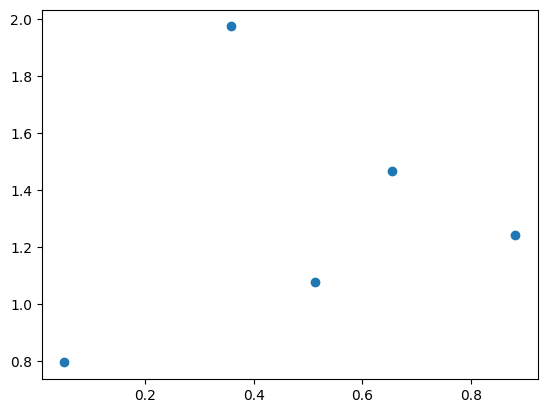

In [2]:
# Generating inital values for Wall slip parameters

#tau_w_range = [0.001, 1] 
#m_range = [0.5, 2]

lower= [0.001, 0.5]
upper = [1, 2]

sampler = qmc.LatinHypercube(d=2)
sample = sampler.random(5)

scaled_values = qmc.scale(sample, lower, upper)
tau_w_values = scaled_values[:,0]
m_values = scaled_values[:,1]
plt.scatter(tau_w_values, m_values)
plt.show()


In [3]:
def calculate_area_between_curves(real_time, real_disp, guess_time, guess_disp):
    guess_disp_interpolated = np.interp(real_time, guess_time, guess_disp)
    diff_disp = np.abs(real_disp - guess_disp_interpolated)
    area = np.trapezoid(diff_disp, real_time)

    return area

file_directory = Path("H:\\XMLFiles")
real_data_directory = "H:\\Real_data\\press_displacement_real.xml"
areas = []

real_tree = ET.parse(real_data_directory)
real_root = real_tree.getroot()
real_data = []

for time_block, dept_block in zip(real_root.findall('.//Block//IndpVar'), real_root.findall('.//Block')):
    time_value = time_block.attrib.get('Value')
    dept_value = dept_block.find('DeptValues').text.strip()
    real_data.append((time_value, dept_value))

real_data_array = np.array([(float(x), float(y)) for x, y in real_data])
real_time = real_data_array[:, 0]  
real_disp = real_data_array[:, 1]  


def process_xml_file(file_directory):
    try:

        guess_tree = ET.parse(file_directory)
        guess_root = guess_tree.getroot()
        guess_data = []

        
        for time_block, dept_block in zip(guess_root.findall('.//Block//IndpVar'), guess_root.findall('.//Block')):
            time_value = time_block.attrib.get('Value')
            dept_value = dept_block.find('DeptValues').text.strip()
            guess_data.append((time_value, dept_value))

        
        guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
        guess_time = guess_data_array[:, 0]  
        guess_disp = guess_data_array[:, 1]  

        print(f"Time data: {guess_time}")
        print(f"Displacement data: {guess_disp}")
        
        

    except Exception as e:
        print(f"Failed to process XML file {file_directory}: {e}")





In [4]:
Synergy = win32com.client.Dispatch("synergy.Synergy")
Synergy.SetUnits("Metric")
moldflow = "C:\\Program Files\\Autodesk\\Moldflow Insight 2023\\bin"


Synergy.OpenProject("H:\\Moldflow_Projects\\wall_slip\\wall_slip.mpi")
Project = Synergy.Project
Project.OpenItemByName("60SurfaceCoverage_study", "Study")

# Simulation loop for wall slip parameters
for i in range(5):
    tau_w = tau_w_values[i]
    m = m_values[i]
    print(f"Simulation {i+1} with tau_w : {tau_w} and m: {m}")

    study_name =f"study_{i+1}"
    Project = Synergy.Project
    
    PropEd = Synergy.PropertyEditor
    Prop = PropEd.FindProperty(10090, 1)
    DVec = Synergy.CreateDoubleArray
    
    DVec.AddDouble(tau_w)
    DVec.AddDouble(m)
    DVec.AddDouble(1e-08)
    DVec.AddDouble(0)
    DVec.AddDouble(0)
    
    Prop.FieldValues(51182, DVec)
          
    PropEd.CommitChanges("Process Conditions")

    StudyDoc = Synergy.StudyDoc
    StudyDoc.SaveAs(study_name)

    p = subprocess.Popen(
    [os.path.join(moldflow, "runstudy.exe"), f"H:\\Moldflow_Projects\\wall_slip\\study_{i+1}.sdy"],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    )
    (output, err) = p.communicate()

    PlotManager = Synergy.PlotManager
    Plot = PlotManager.FindPlotByName2("Press displacement:XY Plot", "Press displacement")
    Viewer = Synergy.Viewer
    Viewer.ShowPlot(Plot)
    Plot = Viewer.ActivePlot
    Plot.SaveResultInXML(f"H:\\XMLFiles\\study_{i + 1}.xml")

    guess_tree = ET.parse(f"H:\\XMLFiles\\study_{i + 1}.xml")
    guess_root = guess_tree.getroot()
    guess_data = []

        
    for time_block, dept_block in zip(guess_root.findall('.//Block//IndpVar'), guess_root.findall('.//Block')):
            time_value = time_block.attrib.get('Value')
            dept_value = dept_block.find('DeptValues').text.strip()
            guess_data.append((time_value, dept_value))

        
    guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
    guess_time = guess_data_array[:, 0]  
    guess_disp = guess_data_array[:, 1]  
    
    area_data = []
    area = calculate_area_between_curves(real_time, real_disp, guess_time, guess_disp)
    area_data.append(area)
    print(area_data)
# Write the output to a log file
    with open(f"H:\\Log_Files\\study_{i+1}.log", "w") as file:
        file.write(output.decode("windows-1252").strip())

Simulation 1 with tau_w : 0.5128730617898078 and m: 1.0760252696605488


com_error: (-2147023170, 'Der Remoteprozeduraufruf ist fehlgeschlagen.', None, None)